# Introduction

Current explanation of QPOs/QPEs in low-redshift galaxies is of a compact secondary orbiting an accreting supermassive black hole in the galactic center. These systems, if emitting at the right frequencies, can thus act as EM counterparts of EMRIs. 

For these EMRIs to be observable in, both, EM and LISA band, they must be emitting QPE signals in the correct frequency band. Observations of QPEs in these bands could thus be very insightful for prospects with LISA EMRIs. 

In this notebook, we use the EMRI catalog generated by Pozzoli et al in https://arxiv.org/abs/2302.07043 to predict the frequency range in which LISA EMRIs will currently be emitting QPE signals. We first distribute the Pozzoli sources uniformly in time from 2034-2038 (expected LISA operation time) and then back evolve each EMRI to the year 2024 using the simplified Peters waveform described in https://arxiv.org/abs/2007.14403 and record forb and e of each EMRI 'today'. Observation of QPEs in these bands and modeling them with LISA EMRIs will strengthen the science case of LISA EMRIs. 

In [1]:
#imports

import os
from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import cupy as cp
from scipy.special import jn
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed

#=== 5PN AAK imports ================

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

traj = EMRIInspiral(func='pn5')

#=== constants =========================

G = 6.67259e-11
C = 299792458.
SM = 1.98892e30
SMsec = G*SM/C/C/C
GPC = 3.0856775807e25
GPCsec = GPC/C
YR = 31558149.8
AU = 1.4959787066e11
AUsec = AU/C
HS3 = np.sqrt(3)/2.
L = 2.5e9

#definitions of constants taken from FEW package
MSUN = 1.98848e30 #Mass of sun in SI
YRSID = 31558149.763545603 #seconds in one year 
G = 6.674080e-11 #Gravitational constant in SI
c = 299792458. #speed of light in SI
Gpc = 3.0856775814913674e+25 #1 Gigaparsec in SI
pi = np.pi 
#emm = (M*MSUN*mu*MSUN)**(3/5)/(M*MSUN+mu*MSUN)**(1/5) #chirp mass in SI units
H0 = 70e6 #Hubble constant in m/s/Gpc

In [2]:
#defining Sensitivity curve (for 1 year) 
def PetersSens(f):
    fa = 0.4e-3
    fb = 25e-3
    
    S1 = 5.76e-48*(1+(fa/f)**2)
    S2 = 3.6e-41
    R = 1 + (f/fb)**2
    
    A = 1.28e-44
    alpha = 1.63
    
    f1 = 10**(-2.704) #for Tobs = 1 year
    f2 = 10**(-3.318)
    fk = 10**(-2.378) #for Tobs = 1 year
    
    Sc = A/2*np.e**(-(f/f1)**alpha)*f**(-7/3)*(1+np.tanh((fk-f)/f2))
    
    return 10/3*(S1/(2*pi*f)**4 + S2)*R + Sc

def sensitivity(f):
    
    #Defining supporting functions
    L = 2.5e9 #m
    fstar = 19.09e-3 #Hz
    
    P_OMS = (1.5e-11**2)*(1+(2e-3/f)**4) #Hz-1
    P_acc = (3e-15**2)*(1+(0.4e-3/f)**2)*(1+(f/8e-3)**4) #Hz-1
    
    #S_c changes depending on signal duration (Equation 14 in 1803.01944)
    #for 1 year
    alpha = 0.171
    beta = 292
    kappa = 1020
    gamma = 1680
    fk = 0.00215
    #log10_Sc = (np.log10(9)-45) -7/3*np.log10(f) -(f*alpha + beta*f*np.sin(kappa*f))*np.log10(np.e) + np.log10(1 + np.tanh(gamma*(fk-f))) #Hz-1 
    
    A=9e-45
    Sc = A*f**(-7/3)*np.exp(-f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(fk-f)))
    
    return (10/(3*L**2))*(P_OMS+4*(P_acc)/((2*np.pi*f)**4))*(1 + 6*f**2/(10*fstar**2))+Sc

#Defining the inner product (this runs on the GPU)
def inner_product(a,b):
    #Taking the FFTs of a and b
    n = max((len(a),len(b)))
    f = rfftfreq(n)/dt
    df = 1/(n*dt)
    atilde_real = rfft(a.real*dt, n=n)[1:]
    btilde_real = rfft(b.real*dt, n=n)[1:]

    plus_prod = cp.conj(atilde_real)@(btilde_real/sensitivity(f[1:]))

    atilde_imag = rfft(a.imag*dt, n=n)[1:]
    btilde_imag = rfft(b.imag*dt, n=n)[1:]

    cross_prod = cp.conj(atilde_imag)@(btilde_imag/sensitivity(f[1:]))
    return 4*df*cp.real(plus_prod+cross_prod)

### Importing the EMRI catalog

In [3]:
def Keplerian_p_from_f(M, mu, f_orb_0, e0):
    return c**2*(1-e0**2)/(2*np.pi*f_orb_0*G*(M+mu)*MSUN)**(2/3)

In [4]:
Tgw_max = 100 #maximum time to plunge from the time of parameter recording
T_init = 2001. #Year when observations of EM transients can begin
T_LISA = 2037. #Year when LISA becomes active
T_obs = 4 #number of years for which LISA will be operational

filename = 'Full_Mratio_2001'

dataframe = pd.read_hdf('sampling_EMRImodel1nospin.bin_0') #import the M1 EMRI catalog of Babak et al.

print(len(dataframe.Tgw))

#model upper-limit motivated screens
df = dataframe[dataframe.Tgw<=Tgw_max]
df = df[df.Tgw>=0.1]
df = df[df.e<=0.8]
df = df[df.q<=1e-4]
#df = df[df.q>=1e-6]


#model lower-limit motivated screens
df = df[df.e>0.0]
df = df[np.abs(np.cos(df.inc))>=0.01]
#df = df[Keplerian_p_from_f((10**df.l_m1)*(1+df.z),df.q*10**(df.l_m1)*(1+df.z),10**df.l_f,df.e)>5]
#df = df[10**df.l_m1*df.q*(1+df.z)<=40]
print(len(df.Tgw))

print(len(df.Tgw)*100/len(dataframe.Tgw))

#df = df[::10]
print(len(df.Tgw))

1225158
63783
5.206104029031358
63783


In [6]:
print(df)

              z    l_m1         q       l_f         e        Tgw     R_LSO  \
50       2.3909  6.0548  0.000009 -3.907487  0.194423  87.186387  5.554975   
66       2.3909  6.0548  0.000009 -3.730384  0.131353  30.793737  5.554975   
74       2.3909  6.0548  0.000009 -3.794537  0.151873  45.351559  5.554975   
90       2.3909  6.0548  0.000009 -3.670643  0.114473  21.230136  5.554975   
136      2.3909  6.0548  0.000009 -3.883917  0.184853  76.294547  5.554975   
...         ...     ...       ...       ...       ...        ...       ...   
1225087  1.5692  5.6690  0.000021 -3.856742  0.616478  39.571107  2.489367   
1225088  1.5692  5.6690  0.000021 -3.823485  0.600167  35.970746  2.489367   
1225089  1.5692  5.6690  0.000021 -3.651629  0.509198  20.841946  2.489367   
1225092  1.5692  5.6690  0.000021 -3.835322  0.606025  37.225970  2.489367   
1225126  1.0443  5.3870  0.000041 -3.375210  0.624277   4.388035  3.783427   

         ww    spin     inc  
50       47  0.9980  1.6843  
66 

(array([ 723., 2962., 5282., 6988., 8045., 9603., 8992., 8389., 7086.,
        5713.]),
 array([0.0389 , 0.48471, 0.93052, 1.37633, 1.82214, 2.26795, 2.71376,
        3.15957, 3.60538, 4.05119, 4.497  ], dtype=float128),
 <BarContainer object of 10 artists>)

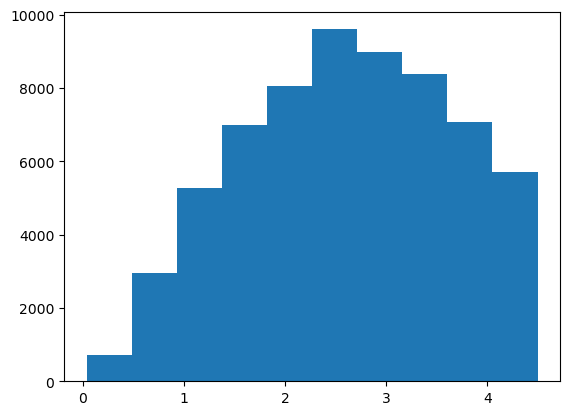

In [7]:
plt.hist(df.z)

### Adding a new column 'T_band' in the dataframe. T_band $\in U(2034,2037)$
### T_band is the time in the LISA band when the EMRI parameters were recorded

In [5]:
np.random.seed(40)
T_band = np.random.choice(np.linspace(T_LISA+0.1,T_LISA+T_obs-0.1,len(df.Tgw)),len(df.Tgw),replace=True)
df['T_band'] = T_band

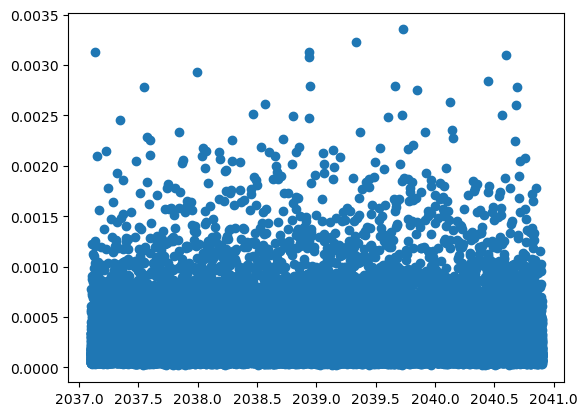

In [6]:
#visualizing the catalog points
plt.scatter(df.T_band,10**df.l_f)

### Back-evolving using the Simplified Peters waveform until some T_init

In [7]:
#supporting functions

def eff(e):
    #eccentricity as input
    return (1/(1-e**2)**(7/2))*(1 + 73/24*e**2 + 37/96*e**4)
    
def gee(e):
    #eccentricity as input
    return (1/(1-e**2)**(5/2))*(304*e+121*e**3)

from scipy.integrate import odeint

def coupledODE(z, t):
    #print(emm)
    dxdt = ((96*G**(5/3))/(5*c**5)*(2*pi)**(8/3)*emm[-1]**(5/3)*z[0]**(11/3)*eff(z[1]))
    dydt = (-(G**(5/3))/(15*c**5)*(2*pi)**(8/3)*emm[-1]**(5/3)*z[0]**(8/3)*gee(z[1]))
    dzdt = [dxdt, dydt]
    return dzdt

def ODEeval_back(forb0,e0,emm,T=1):
    #forb0 in source frame
    
    dt_interp = np.abs(T)*20000
    
    z0 = [forb0,e0]
    #print(z0)
    #taking time steps from the FEW trajectory evaluation
    time_steps = np.linspace(0,T*YRSID,np.abs(int(T*YRSID/dt_interp)))
    #dt = (time_steps[-1]-time_steps[0])/len(time_steps)

    out = odeint(coupledODE, z0, time_steps)

    forbt = np.array(out[:,0])
    et = np.array(out[:,1])
        
    #rethink the sanity checks
    '''
    #making sure forbt is strictly decreasing
    for i in range(1,len(forbt)):
        if forbt[i] >= forbt[i-1]:
            forbt[i] = 0
                    
    forbt_new = forbt[forbt!=0]
    et = et[forbt!=0]
    
    forbt = forbt_new
        
    
    forbt_new = forbt[forbt<1]
    et = et[forbt<1]
    
    forbt = forbt_new
    
    forbt_new = forbt[forbt>=forb0]
    et = et[forbt>=forb0]
    
    forbt = forbt_new
    
    et_new = et[et>1e-3]
    forbt = forbt[et>1e-3]
    
    et = et_new
    
    et_new = et[et<=e0]
    forbt = forbt[et<=e0]
    
    et = et_new
    '''

    #cleaning out non-sensical traj points from the ode solver
    #et_new = et[et>1e-3]
    #et_nn = et_new[et_new<=e0]
    #forbt_new = forbt_new[et>1e-3]
    #forbt_new = forbt_new[et_new<=e0]
    #forbt_nn = forbt_new[forbt_new<1]
    #forbt_nnn = forbt_nn[forbt_nn>=forb0]
    #et_nnn = et_nn[forbt_new<1]
    #et_nnnn = et_nnn[forbt_nn>=forb0]
    
    #forbt = forbt_nnn
    #et = et_nnnn
        
    return time_steps[:len(et)],forbt,et

def ODEeval_forward(forb0,e0,emm,T=1):
    #forb0 in source frame
    
    dt_interp = T*40000
    
    z0 = [forb0,e0]
    #taking time steps from the FEW trajectory evaluation
    time_steps = np.linspace(0,T*YRSID,int(T*YRSID/dt_interp))
    #dt = (time_steps[-1]-time_steps[0])/len(time_steps)

    out = odeint(coupledODE, z0, time_steps)

    forbt = np.array(out[:,0])
    et = np.array(out[:,1])
    
    #making sure forbt is strictly increasing
    for i in range(1,len(forbt)):
        if forbt[i] <= forbt[i-1]:
            forbt[i] = 0
            
    forbt_new = forbt[forbt!=0]
    et = et[forbt!=0]
    
    forbt = forbt_new
    
    forbt = forbt[et!=0]
    et = et[et!=0]
    
    forbt_new = forbt[forbt<1]
    et = et[forbt<1]
    
    forbt = forbt_new
    
    forbt_new = forbt[forbt>=forb0]
    et = et[forbt>=forb0]
    
    forbt = forbt_new
    
    et_new = et[et>1e-3]
    forbt = forbt[et>1e-3]
    
    et = et_new
    
    et_new = et[et<=e0]
    forbt = forbt[et<=e0]
    
    et = et_new

    #cleaning out non-sensical traj points from the ode solver
    #et_new = et[et>1e-3]
    #et_nn = et_new[et_new<=e0]
    #forbt_new = forbt_new[et>1e-3]
    #forbt_new = forbt_new[et_new<=e0]
    #forbt_nn = forbt_new[forbt_new<1]
    #forbt_nnn = forbt_nn[forbt_nn>=forb0]
    #et_nnn = et_nn[forbt_new<1]
    #et_nnnn = et_nnn[forbt_nn>=forb0]
    
    #forbt = forbt_nnn
    #et = et_nnnn
        
    return time_steps[:len(et)],forbt,et


#power in nth harmonic
from scipy.special import jv
from scipy.interpolate import CubicSpline
#supporting functions
#powerfrac equivalent to func defined in Eqn 12 of arXiv:2007.14403
def powerfrac(n,e):
    return (n**4/32)*((jv(n-2,n*e)-2*e*jv(n-1,n*e)+(2/n)*jv(n,n*e)\
                      +2*e*jv(n+1,n*e)-jv(n+2,n*e))**2\
                     + (1-e**2)*(jv(n-2,n*e)-2*jv(n,n*e)+jv(n+2,n*e))**2\
                     +(4/(3*n**2))*jv(n,n*e)**2)

#power equivalent to func defined in Eqn 11 of arXiv:2007.14403
def power(n,e,forb):
    #print((32*G**(7/3))/(5*c**5)*(2*pi*emm*forb)**(10/3)*powerfrac(n,e))
    return (32*G**(7/3))/(5*c**5)*(2*pi*emm*forb)**(10/3)*powerfrac(n,e)

def get_nmodes(e0):
    #try 30*e0 modes but minimum 6 modes. BaracknCutler
    n = np.linspace(1,max(1,int(30*e0)),max(1,int(30*e0))) #change to define upper limit on n based on fractional power
    if n[-1] < 6:
        n = np.linspace(1,6,6)
    #print(n)
    return n

#spectraldist equivalent to func defined in Eqn 18 of arXiv:2007.14403 

def spectraldist(f,forb,e,z):
    n = get_nmodes(e[0])
    freqs = f*(1+z)/n #harmonics in source frame
    #freqs = f/n

    #print(freqs)
    #print(forb)
    
    #making sure harmonics are chosen only from the range of forbt
    freqs = freqs[freqs>=forb[0]] #assumes forbt is source frame
    freqs = freqs[freqs<=forb[-1]]
    freqs_n = (f*(1+z)/freqs).astype(int)
    
    #print(freqs,freqs_n)
    en = CubicSpline(forb, e)(freqs)
    
    #plt.scatter(freqs,en)
    
    gn = powerfrac(freqs_n,en)
    #print(gn)
    effn = eff(en)
    #print(2**(2/3)*np.sum(gn/(freqs_n**(2/3)*effn)))
    return 2**(2/3)*np.sum(gn/(freqs_n**(2/3)*effn))
    
    
#spectrum = []

def hc2(f,forb,e,z,M,mu):
    #f is detector frame frequencies
    #forb evolution is source-frame
    #M and mu are source frame
    
    emm = (M*MSUN*mu*MSUN)**(3/5)/(M*MSUN+mu*MSUN)**(1/5) #chirp mass in SI units in source frame
    
    H0 = 70e6
    
    dist = c*z/H0
    
    hcsq = []
    for i in range(len(f)):
        hcsq.append((2*G**(5/3)*pi**(2/3)*(emm*(1+z))**(5/3)*\
               f[i]**(-1/3))/(3*c**3*pi*(dist*Gpc)**2)*spectraldist(f[i],forb,e,z))
        
    return hcsq

def wavespectrum(wave):
    n = len(wave)
    f = rfftfreq(n)/dt
    df = 1/(n*dt)
    atilde_reastagnantstagnantl = rfft(wave.real*dt, n=n)[1:]
    plus_prod = cp.conj(atilde_real)*(atilde_real)

    atilde_imag = rfft(wave.imag*dt, n=n)[1:]
    cross_prod = cp.conj(atilde_imag)*(atilde_imag)

    return cp.asnumpy(cp.real(plus_prod+cross_prod)*4*df)


### Execution Cell -- Can skip ahead if data already available

In [ ]:
ncpus = 16

from scipy.integrate import simps

z_cat = np.array(df.z)
l_m1_cat = np.array(df.l_m1)
q_cat = np.array(df.q)
e_cat = np.array(df.e)
Tgw_cat = np.array(df.Tgw)
spin_cat = np.array(df.spin)
inc_cat = np.array(df.inc)
l_f = np.array(df.l_f)
T_band_cat = np.array(df.T_band)

#setting a random seed for all the parameters with randomly generated values
Phi_phi0_cat = np.zeros(len(z_cat))
Phi_theta0_cat = np.zeros(len(z_cat))
Phi_r0_cat = np.zeros(len(z_cat))

np.random.seed(40)
qS_cat = np.random.choice(np.linspace(0.1,pi-0.1,1000),size=len(z_cat))
phiS_cat = np.random.choice(np.linspace(0.1,2*pi-0.1,1000),size=len(z_cat))
qK_cat = np.random.choice(np.linspace(0.1,pi-0.1,1000),size=len(z_cat))
phiK_cat = np.random.choice(np.linspace(0.1,2*pi-0.1,1000),size=len(z_cat))

SNR_cat = np.zeros(len(z_cat),dtype=np.float128)
#time_cat = np.zeros(len(z_cat),dtype=np.float128)
#R_LSO_cat = np.zeros(len(z_cat),dtype=np.float128)
#forb_init_cat = np.zeros(len(z_cat),dtype=np.float64)
#e_init_cat = np.zeros(len(z_cat),dtype=np.float64)

f = np.linspace(1e-5,1e-2,1000) #detector frame LISA frequencies
emm = []

def SNRCalc(i):
#for i in tqdm(range(len(z_cat))):
    #print(i)
    ts = time.time()

    z = np.float64(z_cat[i])
    
    forb0 = np.float64(10**l_f[i])*(1+z) #l_f = detector
    M = np.float64(10**l_m1_cat[i]) #source
    mu = np.float64(M*q_cat[i]) #source
    e0 = np.float64(e_cat[i]) #frame invariant
    Tgw = np.float64(Tgw_cat[i])/(1+z) #?? #chang - 'Tgw = detector'
    T_band = np.float64(T_band_cat[i])
    
    T_back = T_init - T_band #T_back is negative for the ODE integrator
    
    T_forward = min(T_band+Tgw,T_LISA+T_obs)-T_band #T_forward is from time of param recording to plunge/LISA end time
    
    emm.append((M*MSUN*mu*MSUN)**(3/5)/(M*MSUN+mu*MSUN)**(1/5)) #chirp mass in SI units (source frame)

    time_steps_back, forbt_back, et_back = ODEeval_back(forb0,e0,emm,T_back)
    time_steps_forward, forbt_forward, et_forward = ODEeval_forward(forb0,e0,emm,T_forward)
    
    #combining the back and forward evolution
    forbt = np.append(forbt_back[::-1],forbt_forward)
    et = np.append(et_back[::-1],et_forward)
    time_steps = np.append(time_steps_back[::-1],time_steps_forward)
    
    #now, forbt is in source frame!
    
    def SNR(f,forbt,et,z,M,mu):
        #forbt and et inverted because we need a strictly increasing sequence
        return np.sqrt(simps(hc2(f,forbt,et,z,M,mu)/f/(PetersSens(f)),x=np.log(f)))

    #plt.plot(f,np.sqrt(hc2(f,forbt,et,z,M,mu)))
    
    SNR_back = SNR(f, forbt_back[::-1][-int(T_back/(T_band-T_LISA)):], et_back[::-1][-int(T_back/(T_band-T_LISA)):], z, M, mu)
    
    if len(forbt_forward) > 1:
        SNR_forward = SNR(f, forbt_forward, et_forward, z, M, mu)
    else:
        SNR_forward = 0
        
    SNR_i = np.sqrt(SNR_back**2 + SNR_forward**2)
    #SNR_i = 0
    
    return SNR_i, forbt, et, time_steps

result = Parallel(n_jobs=ncpus)(delayed(SNRCalc)(i) for i in tqdm(range(len(z_cat))))

SNR_cat = np.array(result)[:,0]
forbt_cat = np.array(result)[:,1] #WARNING: forbt_cat IS IN SOURCE FRAME
et_cat = np.array(result)[:,2]
time_steps_cat = np.array(result)[:,3]

padded_N = 2500

forbt_cat_savetxt = np.zeros((len(forbt_cat),padded_N))

for i in range(len(forbt_cat)):
    forbt_cat_i = np.zeros(padded_N)
    for j in range(padded_N):
        if j < len(np.array(forbt_cat[i])):
            forbt_cat_i[j] = forbt_cat[i][j]
        else:
            forbt_cat_i[j] = forbt_cat[i][-1]
        
    forbt_cat_savetxt[i] = forbt_cat_i
    
#forbt_cat_savetxt = np.array(forbt_cat_savetxt)
#forbt_cat_savetxt = forbt_cat_savetxt.reshape((len(forbt_cat),len(forbt_cat[0])))

print(forbt_cat_savetxt.shape)


et_cat_savetxt = np.zeros((len(et_cat),padded_N))

for i in range(len(et_cat)):
    et_cat_i = np.zeros(padded_N)
    for j in range(padded_N):
        if j < len(np.array(et_cat[i])):
            et_cat_i[j] = et_cat[i][j]
        else:
            et_cat_i[j] = et_cat[i][-1]
        
    et_cat_savetxt[i] = et_cat_i
    
#forbt_cat_savetxt = np.array(forbt_cat_savetxt)
#forbt_cat_savetxt = forbt_cat_savetxt.reshape((len(forbt_cat),len(forbt_cat[0])))

print(et_cat_savetxt.shape)

time_steps_cat_savetxt = np.zeros((len(time_steps_cat),padded_N))

for i in range(len(time_steps_cat)):
    time_steps_cat_i = np.zeros(padded_N)
    for j in range(padded_N):
        if j < len(np.array(time_steps_cat[i])):
            time_steps_cat_i[j] = time_steps_cat[i][j]
        else:
            time_steps_cat_i[j] = time_steps_cat[i][-1]
        
    time_steps_cat_savetxt[i] = time_steps_cat_i
    
#forbt_cat_savetxt = np.array(forbt_cat_savetxt)
#forbt_cat_savetxt = forbt_cat_savetxt.reshape((len(forbt_cat),len(forbt_cat[0])))

print(time_steps_cat_savetxt.shape)

np.savetxt(f'SNR_cat_{filename}.txt',SNR_cat)
np.savetxt(f'forbt_cat_{filename}.txt',forbt_cat_savetxt)
np.savetxt(f'et_cat_{filename}.txt',et_cat_savetxt)
np.savetxt(f'time_steps_cat_{filename}.txt',time_steps_cat_savetxt)


In [ ]:
print(len(forbt_cat[0]))

### Load saved back-evolution data

In [ ]:
from scipy.integrate import simps

z_cat = np.array(df.z)
l_m1_cat = np.array(df.l_m1)
q_cat = np.array(df.q)
e_cat = np.array(df.e)
Tgw_cat = np.array(df.Tgw)
spin_cat = np.array(df.spin)
inc_cat = np.array(df.inc)
l_f = np.array(df.l_f)
T_band_cat = np.array(df.T_band)

#setting a random seed for all the parameters with randomly generated values
Phi_phi0_cat = np.zeros(len(z_cat))
Phi_theta0_cat = np.zeros(len(z_cat))
Phi_r0_cat = np.zeros(len(z_cat))

np.random.seed(40)
qS_cat = np.random.choice(np.linspace(0.1,pi-0.1,1000),size=len(z_cat))
phiS_cat = np.random.choice(np.linspace(0.1,2*pi-0.1,1000),size=len(z_cat))
qK_cat = np.random.choice(np.linspace(0.1,pi-0.1,1000),size=len(z_cat))
phiK_cat = np.random.choice(np.linspace(0.1,2*pi-0.1,1000),size=len(z_cat))

SNR_cat = np.loadtxt(f'SNR_cat_{filename}.txt')
forbt_cat = np.loadtxt(f'forbt_cat_{filename}.txt')
et_cat = np.loadtxt(f'et_cat_{filename}.txt')
time_steps_cat = np.loadtxt(f'time_steps_cat_{filename}.txt')

### Visualizing the back-evolution

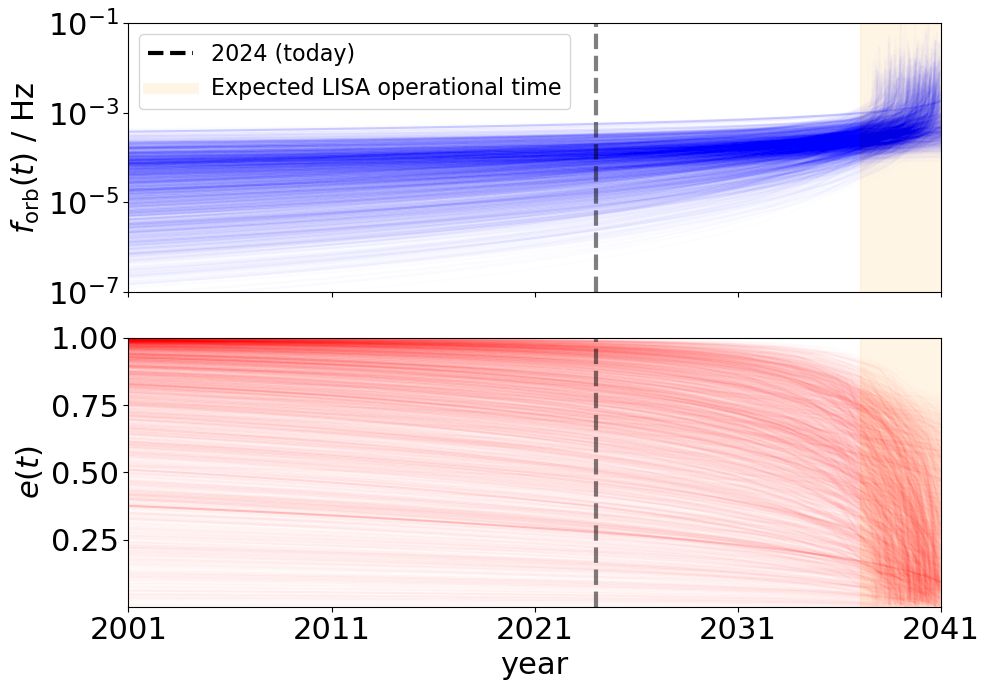

In [8]:
fig, axs = plt.subplots(2,1,figsize=(10,7),sharex=True)

T_init = 2001

for i in range(0,len(z_cat),5):
    axs[0].plot(time_steps_cat[i,::100]/YRSID+T_band[i],(forbt_cat[i,::100]/(1+z_cat[i])),c='b',alpha=150*SNR_cat[i]/np.sum(SNR_cat))
    #axs[0].plot(time_steps_cat[i]/YRSID+T_band[i],forbt_cat[i],c='cyan',alpha=20*SNR_cat[i]/np.sum(SNR_cat))
    axs[1].plot(time_steps_cat[i,::100]/YRSID+T_band[i],et_cat[i,::100],c='r',alpha=150*SNR_cat[i]/np.sum(SNR_cat))
    
axs[0].fill_between(np.linspace(T_LISA,T_LISA+T_obs), 0.1*np.ones(50), color='orange',alpha=0.1)
axs[1].fill_between(np.linspace(T_LISA,T_LISA+T_obs), np.ones(50), color='orange',alpha=0.1)

T_today = 2024

axs[0].plot(T_today*np.ones(50), np.linspace(1e-7,1e-1), 'k--',lw=3,alpha=0.5)
axs[1].plot(T_today*np.ones(50), np.linspace(0.001,1.), 'k--',lw=3,alpha=0.5)

axs[0].set_ylim([1e-7,1e-1])
axs[1].set_ylim([0.001,1.])
axs[1].set_xlim([T_init,T_LISA+T_obs])

axs[0].set_ylabel(r'$f_{\rm orb}(t)$ / Hz',fontsize='22')
axs[1].set_ylabel('$e(t)$',fontsize='22')
plt.xlabel('year',fontsize='22')

plt.subplots_adjust(wspace=0, hspace=0)
#axs[1].set_yscale('log')
axs[0].set_yscale('log')

plt.tick_params(axis='x', which='major', labelsize=22)
plt.xticks(np.linspace(T_init,T_LISA+T_obs,5))
axs[0].tick_params(axis='y', which='major', labelsize=22)
axs[1].tick_params(axis='y', which='major', labelsize=22)

plt.tight_layout()

from matplotlib.lines import Line2D

axs[0].legend([#Line2D([0],[0],c='b'),
               #Line2D([0],[0],c='cyan'),
            Line2D([0],[0],c='k',ls='--', lw=3),
            Line2D([0],[0],c='orange',lw=8,alpha=0.1)],
           [#'Detector frame $f_{orb}(t)$',
            #'Source frame $f_{orb}(t)$',
            '2024 (today)',
            'Expected LISA operational time'],loc=2,fontsize=16)
 
if filename != '':
    plt.savefig(f'evolution_{filename}.png',dpi=300,bbox_inches='tight')

### Extracting forb and e at T_init

In [ ]:
T_today = 2024

T_init = T_today

forb_init_cat = []
e_init_cat = []

for i in range(len(forbt_cat)):
    init_index = np.argmax(np.array(time_steps_cat[i]/YRSID+T_band[i])>T_init)
    forb_init_cat.append(forbt_cat[i][init_index])
    e_init_cat.append(et_cat[i][init_index])
    
forb_init_cat = np.array(forb_init_cat)
e_init_cat = np.array(e_init_cat)

In [ ]:
#Obtaining PMF of forb_init and e_init

SNR_cutoff = 15

forb_init_cut = []
e_init_cut = []
z_cut = []

for i in range(len(forb_init_cat)):
    if SNR_cat[i] >= SNR_cutoff:
        forb_init_cut.append(forb_init_cat[i])
        e_init_cut.append(e_init_cat[i])
        z_cut.append(z_cat[i])
        
forb_init_cut = np.array(forb_init_cut)
e_init_cut = np.array(e_init_cut)
z_cut = np.array(z_cut)
        
PMF_forb, bins_forb = np.histogram(forb_init_cat/(1+z_cat),bins=20)#,weights=SNR_cat/np.sum(SNR_cat))
PMF_e, bins_e = np.histogram(e_init_cat,bins=20)#,weights=SNR_cat/np.sum(SNR_cat))

PMF_forb_cut, bins_forb_cut = np.histogram(forb_init_cut/(1+z_cut),bins=20)
PMF_e_cut, bins_e_cut = np.histogram(e_init_cut,bins=20)
               
fig, axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
#plt.plot(bins_forb[:-1],PMF_forb,'bo')
axs[0].bar(bins_forb[:-1]+bins_forb[1]-bins_forb[0],PMF_forb,width=bins_forb[1]-bins_forb[0],fill=False,edgecolor='k',alpha=0.5)#,label='All EMRIs')
axs[0].bar(bins_forb_cut[:-1]+bins_forb_cut[1]-bins_forb_cut[0],PMF_forb_cut,width=bins_forb_cut[1]-bins_forb_cut[0],fill=False,edgecolor='b',linestyle='--',label=f'LISA SNR $\geq$ {SNR_cutoff}')
axs[0].set_xlabel(r'Detector frame $f_{\rm orb,init}$ / Hz',fontsize=24,labelpad=25)
axs[0].set_ylabel('PMF',fontsize=24)

axs[1].bar(bins_e[:-1]+bins_e[1]-bins_e[0],PMF_e,width=bins_e[1]-bins_e[0],fill=False,edgecolor='k',alpha=0.5)#,label='All EMRIs')
axs[1].bar(bins_e_cut[:-1]+bins_e_cut[1]-bins_e_cut[0],PMF_e_cut,width=bins_e_cut[1]-bins_e_cut[0],fill=False,edgecolor='r',linestyle='--',label=f'LISA SNR $\geq$ {SNR_cutoff}')
axs[1].set_xlabel(r'$e_{\rm init}$',fontsize=24,labelpad=25)

axs[0].legend(fontsize=20)
axs[0].set_yscale('log')
axs[1].legend(fontsize=20)
axs[1].set_yscale('log')

axs[0].tick_params(axis='y', which='major', labelsize=20)
axs[0].tick_params(axis='x', which='major', labelsize=20)

axs[1].tick_params(axis='y', which='major', labelsize=20)
axs[1].tick_params(axis='x', which='major', labelsize=20)

axs[0].ticklabel_format(axis='x', style='sci',scilimits=(-3,1), useMathText= True)
tx = axs[0].xaxis.get_offset_text()
tx.set_fontsize(18)

plt.tight_layout()
#plt.subplots_adjust(hspace=0)

if filename != '':
    plt.savefig(f'PMFs_{filename}.pdf',dpi=300,bbox_inches='tight')

### 'EM detectability' - PMF of mu/dist**2

In [ ]:
def getdist(z):
    #Linear dist-redshift relationship. Can be upgraded.
    return c*z/H0

#Obtaining PMF of forb_init and e_init

mudl2_SNRcut = []
#mudl2_cat = np.array(10**l_m1_cat*q_cat/(getdist(z_cat))**2)
mudl2_cat = np.array(1/(getdist(z_cat))**2)

for i in range(len(mudl2_cat)):
    if SNR_cat[i] >= SNR_cutoff:
        mudl2_SNRcut.append(mudl2_cat[i])
        
mudl2_SNRcut = np.array(mudl2_SNRcut)

PMF_mudl2, bins_mudl2 = np.histogram(mudl2_cat,bins=100)#,weights=SNR_cat/np.sum(SNR_cat))

PMF_mudl2_SNRcut, bins_mudl2_SNRcut = np.histogram(mudl2_SNRcut,bins=100)
               
fig, axs = plt.subplots(1,1,figsize=(6,5),sharey=True)
#plt.plot(bins_forb[:-1],PMF_forb,'bo')
axs.bar(bins_mudl2[:-1],PMF_mudl2,width=bins_mudl2[1]-bins_mudl2[0],fill=False,edgecolor='k',alpha=0.5,label='All EMRIs',align='edge')
axs.bar(bins_mudl2_SNRcut[:-1],PMF_mudl2_SNRcut,width=bins_mudl2_SNRcut[1]-bins_mudl2_SNRcut[0],fill=False,edgecolor='orange',label=f'LISA SNR $\geq$ {SNR_cutoff}',align='edge')
axs.set_xlabel('$ 1 / d_L^2 $')
axs.set_ylabel('PMF')
axs.set_xscale('log')
axs.set_yscale('log')

axs.legend()

if filename != '':
    plt.savefig(f'PMF_mudl2_{filename}.png',dpi=300,bbox_inches='tight')

In [ ]:
mudl2_EMcut = []
forb_init_EMcut = []
z_EMcut = []

#mudl2_cat = np.array(10**l_m1_cat*q_cat/(getdist(z_cat))**2)
mudl2_cat = np.array(1/(getdist(z_cat))**2)

mudl2_cutoff = 1 #1/dl^2 = 4 implies dL = 500 Mpc

for i in range(len(mudl2_cat)):
    if mudl2_cat[i] >= mudl2_cutoff:
        mudl2_EMcut.append(mudl2_cat[i])
        forb_init_EMcut.append(forb_init_cat[i])
        z_EMcut.append(z_cat[i])
        
mudl2_EMcut = np.array(mudl2_EMcut)
forb_init_EMcut = np.array(forb_init_EMcut)
z_EMcut = np.array(z_EMcut)

PMF_mudl2, bins_mudl2 = np.histogram(mudl2_cat,bins=100)#,weights=SNR_cat/np.sum(SNR_cat))

PMF_mudl2_EMcut, bins_mudl2_EMcut = np.histogram(mudl2_EMcut,bins=100)
               
fig, axs = plt.subplots(1,1,figsize=(6,5),sharey=True)
#plt.plot(bins_forb[:-1],PMF_forb,'bo')
axs.bar(bins_mudl2[:-1],PMF_mudl2,width=bins_mudl2[1]-bins_mudl2[0],fill=False,edgecolor='k',alpha=0.5,label='All EMRIs',align='edge')
axs.bar(bins_mudl2_EMcut[:-1],PMF_mudl2_EMcut,width=bins_mudl2_EMcut[1]-bins_mudl2_EMcut[0],fill=False,edgecolor='orange',label=f'$1/d_L^2 \geq {mudl2_cutoff}$',align='edge')
axs.set_xlabel('$ 1 / d_L^2 $')
axs.set_ylabel('PMF')
axs.set_xscale('log')
axs.set_yscale('log')

axs.legend()

if filename != '':
    plt.savefig(f'PMF_mudl2_EMcut_{filename}.png',dpi=300,bbox_inches='tight')

In [ ]:
logSNR = np.zeros(len(SNR_cat),dtype=np.float64)

for i in range(len(SNR_cat)):
    logSNR[i] = np.log10(SNR_cat[i])

fig,axs = plt.subplots(1,1,figsize=(10,6))
plt.scatter(forb_init_cat/(1+z_cat),e_init_cat,c=logSNR,cmap='Purples',s=50)
cb = plt.colorbar()
cb.set_label(label='$log_{10}(SNR)$',size='20')

#plt.scatter(forb_init_cut/(1+z_cut),e_init_cut,c=logSNR_cut,cmap='Blues',s=50)

plt.barh(y=bins_e[:-1],width=1e-8*(PMF_e),height=bins_e[1]-bins_e[0],fill=None,edgecolor='k',alpha=0.6,align='edge',left=-0.5e-4)
plt.bar(bins_forb[:-1],1e-5*PMF_forb,width=bins_forb[1]-bins_forb[0],fill=None,edgecolor='k',alpha=0.6,align='edge',bottom=-0.1) 
#plt.barh(y=bins_e_cut[:-1]+bins_e_cut[1]-bins_e_cut[0],width=1e-6*(PMF_e_cut),height=bins_e_cut[1]-bins_e_cut[0],fill=None,edgecolor='r')
#plt.bar(bins_forb_cut[:-1]+bins_forb_cut[1]-bins_forb_cut[0],1e-3*(PMF_forb_cut),width=bins_forb_cut[1]-bins_forb_cut[0],fill=None,edgecolor='b')

plt.xlabel('Detector frame $f_{orb,init}$ / Hz', fontsize='20')
plt.ylabel('$e_{init}$',fontsize='20')
plt.tick_params(axis='x', which='major', labelsize=18)
plt.ticklabel_format(axis='x', style='sci',scilimits=(-3,1), useMathText= True)

tx = axs.xaxis.get_offset_text()
tx.set_fontsize(18)

plt.tick_params(axis='y', which='major', labelsize=18)

#plt.grid(linestyle='--')
plt.ylim([-0.1,1.])
#plt.xscale('log')
plt.tight_layout()

if filename != '':
    plt.savefig(f'init_{filename}.png',dpi=300,bbox_inches='tight')

In [ ]:
SNR_cut = SNR_cat[SNR_cat >= SNR_cutoff]
EM_cut = mudl2_cat[mudl2_cat >= mudl2_cutoff]

golden_cut = SNR_cut[mudl2_SNRcut >= mudl2_cutoff]
golden_mudl2 = mudl2_SNRcut[mudl2_SNRcut >= mudl2_cutoff]
golden_forb_init = forb_init_cut[mudl2_SNRcut >= mudl2_cutoff]
golden_z = z_cut[mudl2_SNRcut >= mudl2_cutoff]

logSNR = np.zeros(len(SNR_cat),dtype=np.float64)
logSNR_cut = np.zeros(len(SNR_cut),dtype=np.float64)
loggolden_cut = np.zeros(len(golden_cut),dtype=np.float64)

for i in range(len(SNR_cat)):
    logSNR[i] = np.log10(SNR_cat[i])
for i in range(len(SNR_cut)):
    logSNR_cut[i] = np.log10(SNR_cut[i])   
for i in range(len(golden_cut)):
    loggolden_cut[i] = np.log10(golden_cut[i])

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Oranges')
new_cmap = truncate_colormap(cmap,0.2,1.0)
    
fig,axs = plt.subplots(1,1,figsize=(10,6))

#plotting current QPEs/QPOs. Since we are plotting the orbital frequencies of EMRIs, QPE frequencies will need to be halved.
#plt.scatter(1/(2*time_period[QPE_bool]*3600),lumdist[QPE_bool],cmap='Reds',c=np.log10(luminosity[QPE_bool]),s=100,label='QPEs',edgecolors='grey')
#cb = plt.colorbar(pad=-0.05,shrink=0.8)
#cb.set_label(label=r'$log_{10}($'+'Luminosity (erg $s^{-1}$)'+'$)$',labelpad=-110)

#plt.scatter(1/(2*time_period[~QPE_bool]*3600),lumdist[~QPE_bool],cmap='Blues',c=np.log10(luminosity[~QPE_bool]),s=80,label='QPOs',edgecolors='grey')
#plt.colorbar(pad=0.0,shrink=0.8)

#plt.text(1.1/(2*time_period[REJ_bool]*3600),lumdist[REJ_bool],'RE J1034+396',color='midnightblue', va='center',ha='left')

#plotting EMRI catalog data
plt.scatter(forb_init_cat/(1+z_cat),np.sqrt(1/mudl2_cat),c=logSNR,cmap='Greys',s=20,alpha=0.1)#,label='All LISA EMRIs')
plt.fill_between(np.linspace(0.0,1e-3),np.sqrt(1/mudl2_cutoff),y2=1e2,alpha=0.2,color='black')#,label=f'$d_L \geq {np.sqrt(1/mudl2_cutoff)}$ Gpc')
#plt.scatter(forb_init_cut/(1+z_cut),mudl2_SNRcut,color='purple',s=50,alpha=0.5)
#plt.scatter(forb_init_EMcut/(1+z_EMcut),mudl2_EMcut,color='blue',s=50,alpha=0.5)
plt.scatter(golden_forb_init/(1+golden_z),np.sqrt(1/golden_mudl2),cmap=new_cmap,c=loggolden_cut,s=500,marker='*',label=f'LISA SNR $\geq$ {SNR_cutoff},\n $d_L^2 \leq {np.sqrt(1/mudl2_cutoff)} $ Gpc',edgecolor='grey')
cb = plt.colorbar()
cb.set_label(label='$log_{10}(SNR)$',fontsize='20')
PMF_forbinit_golden, bins_forbinit_golden = np.histogram(golden_forb_init/(1+golden_z),bins=10)

plt.bar(bins_forbinit_golden[:-1],1e-2*PMF_forbinit_golden,width=bins_forbinit_golden[1]-bins_forbinit_golden[0],fill=None,edgecolor='k',align='edge',alpha=0.6,bottom=1e-1) 

print('Mean of f_orb (detector): ', np.mean(golden_forb_init/(1+golden_z)))
print('Minimum of f_orb (detector): ', min(golden_forb_init/(1+golden_z)))
print('Maximum of f_orb (detector): ', max(golden_forb_init/(1+golden_z)))

#plt.barh(y=bins_mudl2[:-1],width=5e-7*(PMF_mudl2),height=bins_mudl2[1:]-bins_mudl2[:-1], fill=None,edgecolor='k',alpha=0.6,align='edge',left=-4e-4)
#plt.bar(bins_forb[:-1]+bins_forb[1]-bins_forb[0],5e-6*PMF_forb,width=bins_forb[1]-bins_forb[0],fill=None,edgecolor='k',alpha=0.6,bottom=5e-4) 
#plt.barh(y=bins_e_cut[:-1]+bins_e_cut[1]-bins_e_cut[0],width=1e-6*(PMF_e_cut),height=bins_e_cut[1]-bins_e_cut[0],fill=None,edgecolor='r')
#plt.bar(bins_forb_cut[:-1]+bins_forb_cut[1]-bins_forb_cut[0],1e-3*(PMF_forb_cut),width=bins_forb_cut[1]-bins_forb_cut[0],fill=None,edgecolor='b')

plt.xlabel(r'Detector frame $f_{\rm orb,init}$ / Hz', fontsize='20')
plt.ylabel(r'$d_L$ / Gpc', fontsize='20')
plt.yscale('log')
#plt.xscale('log')
#plt.grid(linestyle='--')
plt.ylim([1e-1,20])
plt.xlim([0.0,7e-4])
plt.legend(loc=1,fontsize=16)
plt.tick_params(axis='x', which='major', labelsize=18)
plt.tick_params(axis='y', which='major', labelsize=18)

plt.ticklabel_format(axis='x', style='sci',scilimits=(-3,1), useMathText= True)

tx = axs.xaxis.get_offset_text()
tx.set_fontsize(18)

plt.tight_layout()
#plt.legend([Line2D([0],[0],c='k',alpha=0.5,lw=8),
#               #Line2D([0],[0],c='cyan'),
#            Line2D([0],[0],c='w',marker='o',markerfacecolor='k',alpha=0.5),
#            Line2D([0],[0],c='purple',marker='*')],
#           ['unobservable in EM',
#            #'Source frame $f_{orb}(t)$',
#            'All EMRIs',
#            'Expected LISA operational time'],loc=1,fontsize=12)


if filename != '':
    plt.savefig(f'init_goldencut_{filename}.png',dpi=300,bbox_inches='tight')

In [ ]:
print(np.mean(golden_forb_init/(1+golden_z)))
print(np.std(golden_forb_init/(1+golden_z)))